In [1]:
import pandas as pd
import numpy as np
import tqdm
import torch

# Pre processing

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import EdgeConv, global_mean_pool

class EdgeNet(nn.Module):
    def __init__(self, input_dim=4, big_dim=32, hidden_dim=2, aggr='mean'):
        super(EdgeNet, self).__init__()
        encoder_nn = nn.Sequential(nn.Linear(2*(input_dim), big_dim),
                               nn.ReLU(),
                               nn.Linear(big_dim, big_dim),
                               nn.ReLU(),
                               nn.Linear(big_dim, hidden_dim),
                               nn.ReLU(),
        )
        
        decoder_nn = nn.Sequential(nn.Linear(2*(hidden_dim), big_dim),
                               nn.ReLU(),
                               nn.Linear(big_dim, big_dim),
                               nn.ReLU(),
                               nn.Linear(big_dim, input_dim)
        )
        
        self.batchnorm = nn.BatchNorm1d(input_dim)

        self.encoder = EdgeConv(nn=encoder_nn,aggr=aggr)
        self.decoder = EdgeConv(nn=decoder_nn,aggr=aggr)

    def forward(self, data):
        data.x = self.batchnorm(data.x)
        data.x = self.encoder(data.x,data.edge_index)
        data.x = self.decoder(data.x,data.edge_index)
        return data.x

In [3]:
import torch
from torch_geometric.data import Data, DataLoader
import os
import os.path as osp
import math
import argparse
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from graph_data import GraphDataset

gdata = GraphDataset(root='/anomalyvol/data/')

input_dim = 4
big_dim = 32
hidden_dim = 2
fulllen = len(gdata)
tv_frac = 0.10
tv_num = math.ceil(fulllen*tv_frac)
splits = np.cumsum([fulllen-2*tv_num,tv_num,tv_num])
batch_size = 512
n_epochs = 1
lr = 0.001
patience = 10
device = 'cuda:0'
model_fname = 'EdgeNet'

model = EdgeNet(input_dim=input_dim, big_dim=big_dim, hidden_dim=hidden_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [4]:
train_dataset = GraphDataset(root='/anomalyvol/data/',start=0,stop=splits[0])
valid_dataset = GraphDataset(root='/anomalyvol/data/',start=splits[1],stop=splits[2])
test_dataset = GraphDataset(root='/anomalyvol/data/',start=splits[0 ],stop=splits[1])

train_loader = DataLoader(train_dataset, batch_size=batch_size, pin_memory=True, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, pin_memory=True, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, pin_memory=True, shuffle=False)

train_samples = len(train_dataset)
valid_samples = len(valid_dataset)
test_samples = len(test_dataset)

print(train_samples)
print(valid_samples)
print(test_samples)

24043
2405
2405


In [5]:
@torch.no_grad()
def test(model,loader,total,batch_size):
    model.eval()
    
    mse = nn.MSELoss(reduction='mean')

    sum_loss = 0.
    t = tqdm.tqdm(enumerate(loader),total=total/batch_size)
    for i,data in t:
        data = data.to(device)
        batch_output = model(data)
        batch_loss_item = mse(batch_output, data.y).item()
        sum_loss += batch_loss_item
        t.set_description("loss = %.5f" % (batch_loss_item))
        t.refresh() # to show immediately the update

    return sum_loss/(i+1)

def train(model, optimizer, loader, total, batch_size):
    model.train()
    
    mse = nn.MSELoss(reduction='mean')

    sum_loss = 0.
    t = tqdm.tqdm(enumerate(loader),total=total/batch_size)
    for i,data in t:
        data = data.to(device)
        optimizer.zero_grad()
        batch_output = model(data)
        batch_loss = mse(batch_output, data.y)
        batch_loss.backward()
        batch_loss_item = batch_loss.item()
        t.set_description("loss = %.5f" % batch_loss_item)
        t.refresh() # to show immediately the update
        sum_loss += batch_loss_item
        optimizer.step()
    
    return sum_loss/(i+1)

In [6]:
n_epochs = 20

In [7]:
stale_epochs = 0
best_valid_loss = 99999
for epoch in range(0, n_epochs):
    loss = train(model, optimizer, train_loader, train_samples, batch_size)
    valid_loss = test(model, valid_loader, valid_samples, batch_size)
    print('Epoch: {:02d}, Training Loss:   {:.4f}'.format(epoch, loss))
    print('               Validation Loss: {:.4f}'.format(valid_loss))

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        modpath = osp.join('/anomalyvol/models/gnn/',model_fname+'.best.pth')
        print('New best model saved to:',modpath)
        torch.save(model.state_dict(),modpath)
        stale_epochs = 0
    else:
        print('Stale epoch')
        stale_epochs += 1
    if stale_epochs >= patience:
        print('Early stopping after %i stale epochs'%patience)
        break

loss = 3930.30835:  98%|█████████▊| 46/46.958984375 [10:38<00:12, 12.89s/it]/opt/conda/lib/python3.7/site-packages/tqdm/std.py:484: TqdmWarning: clamping frac to range [0, 1]
  charset=Bar.ASCII if ascii is True else ascii or Bar.UTF)
loss = 3930.30835: 100%|██████████| 47/46.958984375 [10:38<00:00, 13.59s/it]
loss = 4750.18750: 106%|██████████| 5/4.697265625 [00:10<00:00,  2.03s/it]
  0%|          | 0/46.958984375 [00:00<?, ?it/s]

Epoch: 00, Training Loss:   4068.6996
               Validation Loss: 3990.2174
New best model saved to: /anomalyvol/models/gnn/EdgeNet.best.pth


loss = 3504.74219: 100%|██████████| 47/46.958984375 [04:40<00:00,  5.97s/it]
loss = 3833.99219: 106%|██████████| 5/4.697265625 [00:11<00:00,  2.23s/it]
  0%|          | 0/46.958984375 [00:00<?, ?it/s]

Epoch: 01, Training Loss:   3837.1179
               Validation Loss: 3153.7316
New best model saved to: /anomalyvol/models/gnn/EdgeNet.best.pth


loss = 2081.60474: 100%|██████████| 47/46.958984375 [04:41<00:00,  5.99s/it]
loss = 2580.87354: 106%|██████████| 5/4.697265625 [00:10<00:00,  2.13s/it]
  0%|          | 0/46.958984375 [00:00<?, ?it/s]

Epoch: 02, Training Loss:   2499.9233
               Validation Loss: 2124.7100
New best model saved to: /anomalyvol/models/gnn/EdgeNet.best.pth


loss = 2203.71948: 100%|██████████| 47/46.958984375 [04:45<00:00,  6.08s/it]
loss = 2415.69897: 106%|██████████| 5/4.697265625 [00:10<00:00,  2.11s/it]


Epoch: 03, Training Loss:   2085.8013
               Validation Loss: 2024.9919
New best model saved to: /anomalyvol/models/gnn/EdgeNet.best.pth


loss = 1768.04321: 100%|██████████| 47/46.958984375 [04:43<00:00,  6.03s/it]
loss = 2396.80615: 106%|██████████| 5/4.697265625 [00:10<00:00,  2.17s/it]
  0%|          | 0/46.958984375 [00:00<?, ?it/s]

Epoch: 04, Training Loss:   2055.7708
               Validation Loss: 2014.8364
New best model saved to: /anomalyvol/models/gnn/EdgeNet.best.pth


loss = 2089.86060: 100%|██████████| 47/46.958984375 [04:37<00:00,  5.89s/it]
loss = 2391.83594: 106%|██████████| 5/4.697265625 [00:10<00:00,  2.11s/it]
  0%|          | 0/46.958984375 [00:00<?, ?it/s]

Epoch: 05, Training Loss:   2056.6022
               Validation Loss: 2010.7642
New best model saved to: /anomalyvol/models/gnn/EdgeNet.best.pth


loss = 1887.89954: 100%|██████████| 47/46.958984375 [07:16<00:00,  9.29s/it]   
loss = 2384.35034: 106%|██████████| 5/4.697265625 [00:28<-1:59:59,  5.63s/it]
  0%|          | 0/46.958984375 [00:00<?, ?it/s]

Epoch: 06, Training Loss:   2050.1694
               Validation Loss: 2007.7603
New best model saved to: /anomalyvol/models/gnn/EdgeNet.best.pth


loss = 1989.90027: 100%|██████████| 47/46.958984375 [08:18<00:00, 10.60s/it]
loss = 2386.07690: 106%|██████████| 5/4.697265625 [00:10<00:00,  2.19s/it]


Epoch: 07, Training Loss:   2046.6995
               Validation Loss: 2004.3604
New best model saved to: /anomalyvol/models/gnn/EdgeNet.best.pth


loss = 1918.87927: 100%|██████████| 47/46.958984375 [04:39<00:00,  5.95s/it]
loss = 2380.65503: 106%|██████████| 5/4.697265625 [00:11<00:00,  2.23s/it]
  0%|          | 0/46.958984375 [00:00<?, ?it/s]

Epoch: 08, Training Loss:   2038.5036
               Validation Loss: 1996.2228
New best model saved to: /anomalyvol/models/gnn/EdgeNet.best.pth


loss = 2272.61035: 100%|██████████| 47/46.958984375 [04:42<00:00,  6.00s/it]
loss = 2348.76953: 106%|██████████| 5/4.697265625 [00:10<00:00,  2.09s/it]
  0%|          | 0/46.958984375 [00:00<?, ?it/s]

Epoch: 09, Training Loss:   2024.4453
               Validation Loss: 1964.1164
New best model saved to: /anomalyvol/models/gnn/EdgeNet.best.pth


loss = 1875.61877: 100%|██████████| 47/46.958984375 [04:44<00:00,  6.06s/it]
loss = 2186.17505: 106%|██████████| 5/4.697265625 [00:10<00:00,  2.05s/it]
  0%|          | 0/46.958984375 [00:00<?, ?it/s]

Epoch: 10, Training Loss:   1952.1313
               Validation Loss: 1821.3374
New best model saved to: /anomalyvol/models/gnn/EdgeNet.best.pth


loss = 1641.55237: 100%|██████████| 47/46.958984375 [04:49<00:00,  6.17s/it]
loss = 1850.67688: 106%|██████████| 5/4.697265625 [00:10<00:00,  2.09s/it]
  0%|          | 0/46.958984375 [00:00<?, ?it/s]

Epoch: 11, Training Loss:   1736.0287
               Validation Loss: 1543.1433
New best model saved to: /anomalyvol/models/gnn/EdgeNet.best.pth


loss = 1267.38489: 100%|██████████| 47/46.958984375 [04:45<00:00,  6.07s/it]
loss = 1582.47705: 106%|██████████| 5/4.697265625 [00:10<00:00,  2.15s/it]
  0%|          | 0/46.958984375 [00:00<?, ?it/s]

Epoch: 12, Training Loss:   1502.9735
               Validation Loss: 1354.8158
New best model saved to: /anomalyvol/models/gnn/EdgeNet.best.pth


loss = 1260.86292: 100%|██████████| 47/46.958984375 [04:42<00:00,  6.01s/it]
loss = 1387.07410: 106%|██████████| 5/4.697265625 [00:10<00:00,  2.09s/it]
  0%|          | 0/46.958984375 [00:00<?, ?it/s]

Epoch: 13, Training Loss:   1352.7614
               Validation Loss: 1236.4318
New best model saved to: /anomalyvol/models/gnn/EdgeNet.best.pth


loss = 1234.98706: 100%|██████████| 47/46.958984375 [04:38<00:00,  5.93s/it]
loss = 1273.25818: 106%|██████████| 5/4.697265625 [00:10<00:00,  2.09s/it]
  0%|          | 0/46.958984375 [00:00<?, ?it/s]

Epoch: 14, Training Loss:   1255.3004
               Validation Loss: 1171.0919
New best model saved to: /anomalyvol/models/gnn/EdgeNet.best.pth


loss = 1156.85608: 100%|██████████| 47/46.958984375 [07:00<00:00,  8.96s/it]   
loss = 1214.88647: 106%|██████████| 5/4.697265625 [00:27<-1:59:59,  5.55s/it]


Epoch: 15, Training Loss:   1199.3603
               Validation Loss: 1133.0263
New best model saved to: /anomalyvol/models/gnn/EdgeNet.best.pth


loss = 1074.39917: 100%|██████████| 47/46.958984375 [07:47<00:00,  9.94s/it]
loss = 1168.43555: 106%|██████████| 5/4.697265625 [00:10<00:00,  2.17s/it]


Epoch: 16, Training Loss:   1165.9559
               Validation Loss: 1106.0719
New best model saved to: /anomalyvol/models/gnn/EdgeNet.best.pth


loss = 1053.58691: 100%|██████████| 47/46.958984375 [04:35<00:00,  5.87s/it]
loss = 1138.64087: 106%|██████████| 5/4.697265625 [00:10<00:00,  2.05s/it]


Epoch: 17, Training Loss:   1145.2506
               Validation Loss: 1085.5513
New best model saved to: /anomalyvol/models/gnn/EdgeNet.best.pth


loss = 1039.16528: 100%|██████████| 47/46.958984375 [04:46<00:00,  6.09s/it]
loss = 1113.36487: 106%|██████████| 5/4.697265625 [00:10<00:00,  2.15s/it]


Epoch: 18, Training Loss:   1124.9851
               Validation Loss: 1063.5214
New best model saved to: /anomalyvol/models/gnn/EdgeNet.best.pth


loss = 1005.19800: 100%|██████████| 47/46.958984375 [04:44<00:00,  6.05s/it]
loss = 1080.92383: 106%|██████████| 5/4.697265625 [00:10<00:00,  2.17s/it]

Epoch: 19, Training Loss:   1090.3414
               Validation Loss: 1036.2212
New best model saved to: /anomalyvol/models/gnn/EdgeNet.best.pth


In [8]:
model.load_state_dict(torch.load(modpath))
input_x = []
output_x = []

t = tqdm.tqdm(enumerate(test_loader),total=test_samples/batch_size)
for i, data in t:
    data.to(device)
    input_x.append(data.x.cpu().numpy())
    output_x.append(model(data).cpu().detach().numpy())

106%|██████████| 5/4.697265625 [00:11<00:00,  2.32s/it]


(134117,)
(134117,)


(array([0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 3.0000e+00, 2.0000e+00,
        1.0000e+00, 1.0000e+00, 2.0000e+00, 4.0000e+00, 4.0000e+00,
        6.0000e+00, 6.0000e+00, 4.0000e+00, 1.0000e+01, 1.0000e+01,
        1.4000e+01, 1.6000e+01, 1.3000e+01, 2.2000e+01, 3.5000e+01,
        2.9000e+01, 5.6000e+01, 5.9000e+01, 9.4000e+01, 1.4400e+02,
        1.8900e+02, 3.9100e+02, 7.4300e+02, 1.7850e+03, 3.8930e+03,
        6.3450e+03, 8.7110e+03, 1.0683e+04, 1.3712e+04, 1.6029e+04,
        1.4285e+04, 1.1533e+04, 9.1660e+03, 7.3700e+03, 5.5000e+03,
        4.1620e+03, 3.1280e+03, 2.4760e+03, 1.8040e+03, 1.5170e+03,
        1.2370e+03, 1.0060e+03, 8.6800e+02, 7.5700e+02, 5.8600e+02,
        5.3700e+02, 4.6000e+02, 3.7800e+02, 3.3400e+02, 2.8700e+02,
        2.6200e+02, 2.3100e+02, 2.3400e+02, 1.96

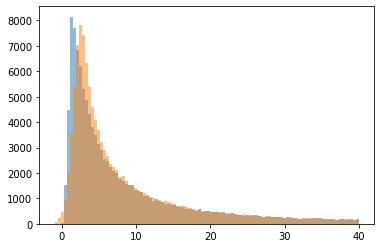

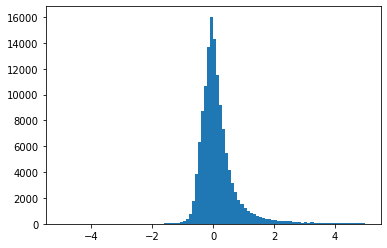

In [37]:
diff = []
output_px = []
input_px = []
for i in range(len(input_x)):
    diff.append(((output_x[i][:,3]-input_x[i][:,3])/input_x[i][:,3]).flatten())
    output_px.append(output_x[i][:,3].flatten())
    input_px.append(input_x[i][:,3].flatten())
    
all_diff = np.concatenate(diff)
all_input_px = np.concatenate(input_px)
all_output_px = np.concatenate(output_px)

print(all_input_px.shape)
print(all_output_px.shape)

plt.figure()
plt.hist(all_input_px, bins=np.linspace(-1, 40, 101),alpha=0.5)
plt.hist(all_output_px, bins=np.linspace(-1, 40, 101),alpha=0.5)

plt.figure()
plt.hist(all_diff, bins=np.linspace(-5, 5, 101))

In [26]:
max(all_input_px)

3245.6025